## Autoregression 

## Autocorrelation

## Persistence Model

## Autoregression Model

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4141: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


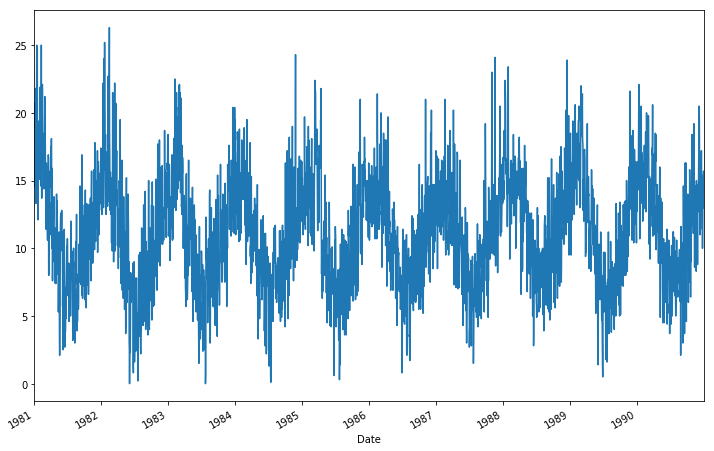

(3650,)

In [13]:
from pandas import Series
from matplotlib import pyplot
series = Series.from_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv', header=0)
fig, ax = pyplot.subplots(figsize=(12,8))
series.plot()
pyplot.show()
series.shape

**We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.**

**A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot.**

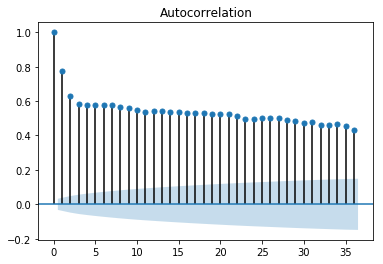

In [12]:
plot_acf(series)
pyplot.show()

Running the example creates a 2D plot showing the lag value along the x-axis and the correlation on the y-axis between -1 and 1.

Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.

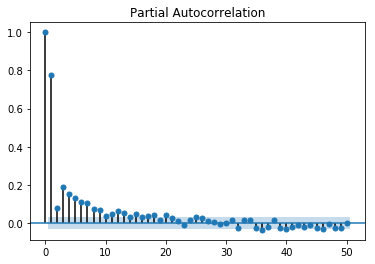

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(series, lags=50)
pyplot.show()

Running the example creates a 2D plot of the partial autocorrelation for the first 50 lags.

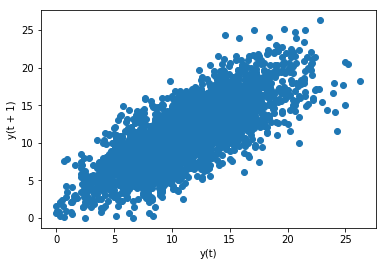

In [18]:
from pandas.plotting import lag_plot
lag_plot(series)
pyplot.show()

We can see a large ball of observations along a diagonal line of the plot. It clearly shows a relationship or **some correlation.**

In [22]:
import pandas as pd
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

         t-1      t+1
t-1  1.00000  0.77487
t+1  0.77487  1.00000


It shows a strong positive correlation (0.77) between the observation and the lag=1 value.

We could manually calculate the correlation values for each lag variable and plot the result. Thankfully, Pandas provides a built-in plot called the ***autocorrelation_plot()*** function.

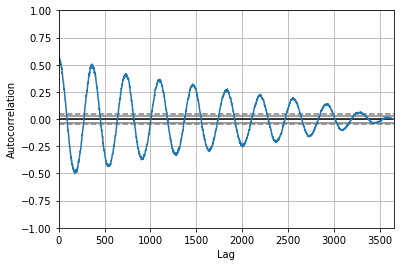

In [24]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
pyplot.show()

Running the example shows the swing in positive and negative correlation as the temperature values change across summer and winter seasons each previous year.

The statsmodels library also provides a version of the plot in the ***plot_acf()*** function as a line plot.

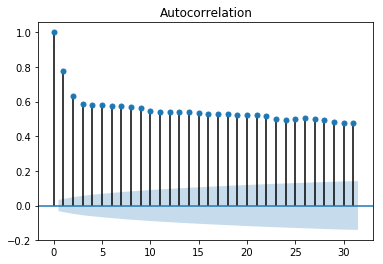

In [25]:
plot_acf(series, lags=31)
pyplot.show()

**Persistence Model**

Let’s say that we want to develop a model to predict the last 7 days of minimum temperatures in the dataset given all prior observations.

The simplest model that we could use to make predictions would be to persist the last observation. We can call this a persistence model and it provides a baseline of performance for the problem that we can use for comparison with an autoregression model.

We can develop a test harness for the problem by splitting the observations into training and test sets, with only the last 7 observations in the dataset assigned to the test set as “unseen” data that we wish to predict.

The predictions are made using a walk-forward validation model so that we can persist the most recent observations for the next day. This means that we are not making a 7-day forecast, but 7 1-day forecasts.

    t-1   t+1
0   NaN  20.7
1  20.7  17.9
2  17.9  18.8
3  18.8  14.6
4  14.6  15.8
5  15.8  15.8
6  15.8  15.8
7  15.8  17.4
8  17.4  21.8
9  21.8  20.0
       t-1   t+1
3640  13.1  13.2
3641  13.2  13.9
3642  13.9  10.0
3643  10.0  12.9
3644  12.9  14.6
3645  14.6  14.0
3646  14.0  13.6
3647  13.6  13.5
3648  13.5  15.7
3649  15.7  13.0
test_X [10.  12.9 14.6 14.  13.6 13.5 15.7]
test_y [12.9 14.6 14.  13.6 13.5 15.7 13. ]
predictions [10.0, 12.9, 14.6, 14.0, 13.6, 13.5, 15.7]
Test MSE: 3.423


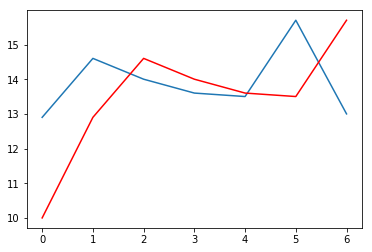

In [38]:
from sklearn.metrics import mean_squared_error
# create lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(10))
print(dataframe.tail(10))
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
print("test_X",test_X)
print("test_y",test_y)
# persistence model
def model_persistence(x):
	return x
 
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
print("predictions",predictions)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

The expected values for the next 7 days are plotted (blue) compared to the predictions from the model (red)

**Autoregression Model**

An autoregression model is a linear regression model that uses lagged variables as input variables.

We could calculate the linear regression model manually using the LinearRegession class in scikit-learn and manually specify the lag input variables to use.

Alternately, the statsmodels library provides an autoregression model that automatically selects an appropriate lag value using statistical tests and trains a linear regression model. It is provided in the AR class.

We can use this model by first creating the model AR() and then calling fit() to train it on our dataset. This returns an ARResult object.

Once fit, we can use the model to make a prediction by calling the predict() function for a number of observations in the future. This creates 1 7-day forecast, which is different from the persistence example above.

The complete example is listed below.

Lag: 29
Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]
predicted=11.871275, expected=12.900000
predicted=13.053794, expected=14.600000
predicted=13.532591, expected=14.000000
predicted=13.243126, expected=13.600000
predicted=13.091438, expected=13.500000
predicted=13.146989, expected=15.700000
predicted=13.176153, expected=13.000000
Test MSE: 1.502


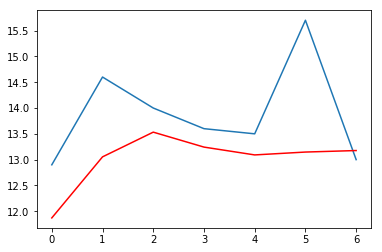

In [27]:
from statsmodels.tsa.ar_model import AR
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=11.871275, expected=12.900000
predicted=13.659297, expected=14.600000
predicted=14.349246, expected=14.000000
predicted=13.427454, expected=13.600000
predicted=13.374877, expected=13.500000
predicted=13.479991, expected=15.700000
predicted=14.765146, expected=13.000000
Test MSE: 1.451


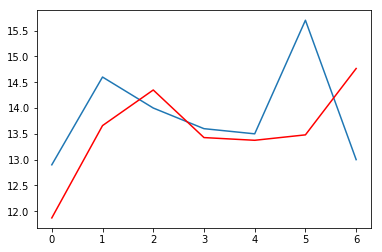

In [28]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

**References** :

---

[machinelearningmastery-AutoCorrelation](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/)

[machinelearningmastery-AutoRegression](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/)

[r-statistics](http://r-statistics.co/Assumptions-of-Linear-Regression.html)